In [1]:
import importlib
from numpy.core.numeric import Inf
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from NNet.utils.writeNNet import writeNNet
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import time
import importlib
import models
import datasets
import math
import utils
from utils import *
import tasks

In [50]:
importlib.reload(datasets)
importlib.reload(tasks)

def training_all():
    task_classes = [
                    (tasks.BloomCrimeTask, 1000), 
                    ]
    for task_class, time_out in task_classes:
        print("task_class: ", task_class, "normal")
        task_class(time_out = time_out).train_and_verify() # normal
        print("task_class: ", task_class, "vanilla")
        task_class(add_counterexample = True, incremental_training = True, time_out=time_out).train_and_verify() # vanilla
        print("task_class: ", task_class, "spec data")
        task_class(add_counterexample = True, incremental_training = True, batch_counterexample = True, time_out=time_out).train_and_verify() # spec data
        print("task_class: ", task_class, "early reject")
        task_class(add_counterexample = True, incremental_training = True, batch_counterexample = True, early_rejection = True, time_out=time_out).train_and_verify() # w/ early rejection
training_all()

task_class:  <class 'tasks.BloomCrimeTask'> normal
Using cuda device
Epoch 1
-------------------------------
Train Error: 
 Accuracy: 79.9%, Avg loss: 1.425601 

time: 0.06735801696777344 1000
Epoch 2
-------------------------------
Train Error: 
 Accuracy: 80.0%, Avg loss: 0.797797 

time: 0.12992191314697266 1000
Epoch 3
-------------------------------
Train Error: 
 Accuracy: 85.4%, Avg loss: 0.624945 

time: 0.19167637825012207 1000
Epoch 4
-------------------------------
Train Error: 
 Accuracy: 88.6%, Avg loss: 0.513376 

testing positive data
Positve data accuracy: 0.9995810640971932
start verifying
121
verified prob for this spec: 0.0
adding counter example, sampling_size= 0
adding counter example, num= 0
verified prob for this spec: 0.0
adding counter example, sampling_size= 0
adding counter example, num= 0
adding counter example, sampling_size= 0
adding counter example, num= 0
adding counter example, sampling_size= 0
adding counter example, num= 0
verified prob for this spec:

In [54]:
def append_neg_data(dataset, task, unit):
    for rect in task.safe_rects:
        size = (rect.hx - rect.lx) * (rect.hy - rect.ly)
        num_samples = int(np.ceil(size/unit))
        x = np.random.uniform(rect.lx, rect.hx, num_samples)
        y = np.random.uniform(rect.ly, rect.hy, num_samples)
        samples = np.vstack((x,y)).T
        for s in samples:
            dataset.append(s, np.zeros(1).astype('float32'))
    return dataset
def to_device(data, device):
    return tuple(tensor.to(device) for tensor in data) if isinstance(data, tuple) else data.to(device)
def test(model, data, batch_size, compute_loss, verbose=False, compute_error=False):
    dataloader = DataLoader(data, batch_size=batch_size)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    digit_size, digit_correct = 0, 0
    positive = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = to_device(X, "cuda")
            y = to_device(y, "cuda")
            if compute_error:
                acc_cnt, loss = compute_loss(model, X, y)
                test_loss += loss.cpu().item() if torch.is_tensor(loss) else loss
                correct += acc_cnt.cpu().item() if torch.is_tensor(acc_cnt) else acc_cnt
    if not compute_error:
        return None, None
    test_loss /= num_batches
    acc = correct * 1. / size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return acc, test_loss
    
def accuracy_comparison(task_classes, verified):
    for task_class, time_out in task_classes:
        task = task_class(add_counterexample = verified, incremental_training = verified, batch_counterexample = verified, time_out=time_out) # wo finetune
        task.load_model("../model/"+task.save_name+".pth")
        task.model.to("cuda")
        task.model.eval()
        neg_data = datasets.EmptyDataset()
        append_neg_data(neg_data, task, 0.0001)

        print(task.save_name)
        param_size = 0
        for param in task.model.parameters():
            param_size += param.nelement() * param.element_size()
        print('model size: {:.3f}KB'.format(param_size / 1024))

        ### latency ###
        batch_size=1
        start = time.time()
        _, _ = test(task.model, task.training_data, batch_size, task.compute_loss, compute_error = False)
        end = time.time()
        
        print("latency time (us): {:.5f}".format((end - start)/len(task.training_data)*1e6))
        # print("pos acc, loss: {:.5f}, {:.5f}".format(pos_acc, pos_loss))
        # print("neg acc, loss: {:.5f}, {:.5f}".format(neg_acc, neg_loss))
        
        ### throughput ###
        batch_size=len(task.training_data)
        rep_times = 100
        start = time.time()
        for i in range(rep_times):
            pos_acc, pos_loss = test(task.model, task.training_data, batch_size, task.compute_loss, compute_error = False)
        end = time.time()
        pos_acc, pos_loss = test(task.model, task.positive_data, batch_size, task.compute_loss, compute_error = True)
        neg_acc, neg_loss = test(task.model, neg_data, batch_size, task.compute_loss, compute_error = True)
        
        print("throughput: {:.5f}".format(len(task.training_data)/((end - start)/rep_times)))
        print("pos acc, loss: {:.5f}, {:.5f}".format(pos_acc, pos_loss))
        print("neg acc, loss: {:.5f}, {:.5f}".format(neg_acc, neg_loss))
        
accuracy_comparison([(tasks.BloomCrimeTask, 1000)], False)

BloomCrimeTask00000-1_1000
model size: 1964.848KB
latency time (us): 84.08837
throughput: 148079.46396
pos acc, loss: 0.99958, 0.08071
neg acc, loss: 0.43714, 2.09872


In [52]:
accuracy_comparison([(tasks.BloomCrimeTask, 1000)], True)

BloomCrimeTask11100-1_1000
model size: 1964.848KB
latency time (us): 85.25622
throughput: 147093.32816
pos acc, loss: 0.99078, 0.29184
neg acc, loss: 0.97838, 0.05650


In [8]:
training_data = datasets.CrimeDataset("../data/bloom_crime/crime.csv", test=False)

../results/DBIndexTask00000-1_300.npz
../results/DBIndexTask11000-1_300.npz
../results/DBIndexTask11100-1_300.npz
../results/DBIndexTask11110-1_300.npz
../results/RedisTask00000-1_300.npz
../results/RedisTask11000-1_300.npz
../results/RedisTask11100-1_300.npz
../results/RedisTask11110-1_300.npz
../results/CardWikiTask00000-1_300.npz
../results/CardWikiTask11000-1_300.npz
../results/CardWikiTask11100-1_300.npz
../results/CardWikiTask11110-1_300.npz
../results/LinnosTask00000-1_300.npz
../results/LinnosTask11000-1_300.npz
../results/LinnosTask11100-1_300.npz
../results/LinnosTask11110-1_300.npz
../results/BloomCrimeTask00000-1_1000.npz
../results/BloomCrimeTask11000-1_1000.npz
../results/BloomCrimeTask11100-1_1000.npz
../results/BloomCrimeTask11110-1_1000.npz
loaded
ploted
saving
../results/BloomCrimeTask11100-1_1001.npz


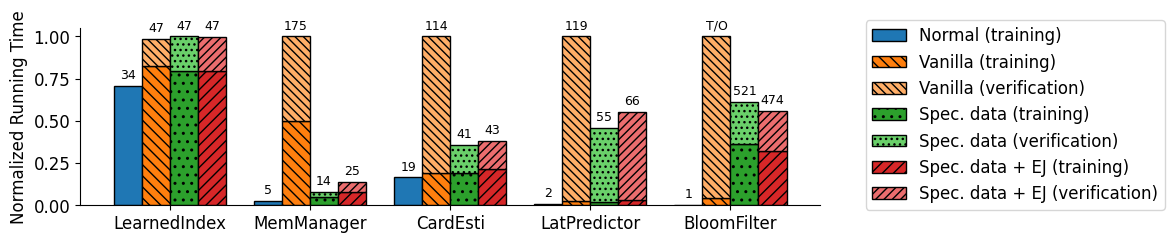

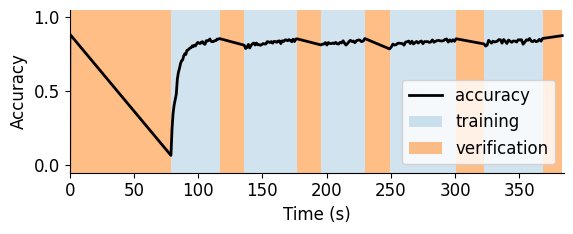

In [53]:

import utils
utils.cluster_bar_graph(
    [
    ("DBIndexTask", "LearnedIndex", 300), 
    ("RedisTask", "MemManager", 300), 
    ("CardWikiTask", "CardEsti", 300),
    ("LinnosTask", "LatPredictor", 300),  
    ("BloomCrimeTask", "BloomFilter", 1000),
    ],
    [
    ("00000-1","Normal"), 
    ("11000-1","Vanilla"), 
    ("11100-1","Spec. data"), 
    ("11110-1","Spec. data + EJ")
    ], 
    "../imgs/tmp.png")

# utils.plot_acc_loss("../results/CardWikiTask11100-1_300.npz", "../imgs/cardesti_acc.pdf")
# utils.plot_acc_loss("../results/RedisTask11100-1_300.npz", "../imgs/redis_acc.pdf")
# utils.plot_acc_loss("../results/LinnosTask11100-1_300.npz", "../imgs/linnos_acc.pdf")
utils.plot_acc_loss("../results/BloomCrimeTask11100-1_1001.npz", "../imgs/bloom_acc_100.png")